Dynamics of continental accretion
======

This notebook outlines the Underworld model used in the Moresi (2014) paper 'Dynamics of continental accretion'. It reproduces the initial conditions shown in Extended Data Figure 1 and 2 and the numerics required for reproduce Figure 2.

"In order to better understand the behaviour of this ancient plate mar- gin and the growth of the Australian continent, we use three-dimensional (3D) dynamic models of a subducting slab, overriding plate and mantle, building on previous work14–16. The models have a four-layer subduct- ing plate with buoyancy and rheology of each layer pre-calculated from a half-space cooling model of 80 or 120 Myr age, and they include either a weak or a strong viscoplastic overriding plate (Table 1 and Extended Data Figs 1 and 2). The simulations are best understood by viewing movies of the time evolution (Table 1)."

**References**

Moresi, L., P. G. Betts, M. S. Miller, and R. A. Cayley. 2014. “Dynamics of Continental Accretion.” Nature 508 (7495): 245–48. [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

In [1]:
# core UW bit
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

from UWGeodynamics import dimensionalise
from UWGeodynamics import non_dimensionalise as nd
from underworld import function as fn

u = GEO.UnitRegistry
#GEO.rcParams['nonlinear.max.iterations'] = 20
#GEO.rcParams['initial.nonlinear.max.iterations'] = 20

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
# 3rd party python modules
import math
import numpy as np
import os
import scipy

In [3]:
gravity = 9.8 * u.meter / u.second**2
Tsurf   = 273.15 * u.degK
Tint    = 1573.0 * u.degK

kappa   = 1e-6   * u.meter**2 / u.second 

boxLength = 6000.0 * u.kilometer
boxHeight =  800.0 * u.kilometer
boxWidth  = 3000.0 * u.kilometer

dRho =   2900. * u.kilogram / u.meter**3 # matprop.ref_density

use_scaling = False

# lithostatic pressure for mass-time-length
ref_stress = dRho * gravity * boxHeight
# viscosity of upper mante for mass-time-length
ref_viscosity = 1e20 * u.pascal * u.seconds

ref_time        = ref_viscosity/ref_stress
ref_length      = boxHeight
ref_mass        = (ref_viscosity*ref_length*ref_time).to_base_units()
ref_temperature = Tint - Tsurf

KL = ref_length       
KM = ref_mass         
Kt = ref_time
KT = ref_temperature

if use_scaling:
    # Disable internal scaling when using relrho_geo_material_properties.py
    KL = 1. * u.meter       
    KM = 1. * u.kilogram        
    Kt = 1. * u.second
    KT = 1. * u.degK

scaling_coefficients = GEO.get_coefficients()

scaling_coefficients["[length]"] = KL.to_base_units()
scaling_coefficients["[time]"]   = Kt.to_base_units()
scaling_coefficients["[mass]"]   = KM.to_base_units()
scaling_coefficients["[temperature]"]   = KT.to_base_units()

if use_scaling:
    import relrho_geo_material_properties as matprop
else:
    import absrho_geo_material_properties as matprop

In [4]:
# shortcuts for parallel wrappers
barrier = GEO.uw.mpi.barrier
rank    = GEO.rank

**Setup parameters**


In [5]:
scr_rtol = 1e-6
ang = 20
nEls = (30,30)
shifted = 650
# nEls = (256,96,96)
# nEls = (16,10,4)
# nEls = (256, 96)
# nEls = (128, 48)

dim = len(nEls)

outputPath = "scalingoutput" if use_scaling else "output"
outputPath = outputPath + "-" + str(scr_rtol) + "-" + str(ang) + "-" + str(shifted) + "-"
outputPath = outputPath + (f"{nEls[0]}x{nEls[1]}x{nEls[2]}" if dim == 3 else f"{nEls[0]}x{nEls[1]}")
outputPath = outputPath + f"_np{GEO.size}"

In [6]:
outputPath = os.path.join(os.path.abspath("."), outputPath)
if rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
barrier()

**Create mesh and finite element variables**

In [7]:
# Define our vertical unit vector using a python tuple
g_mag = 9.8 * u.meter / u.sec**2

if dim == 2:
    minCoord   = (0., -boxHeight)
    maxCoord   = (boxLength, 0.)
    g_vec      = ( 0.0, -1.0 * g_mag )
    
else:
    minCoord   = (0., -boxHeight, 0.)
    maxCoord   = (boxLength, 0., boxWidth)
    g_vec      = ( 0.0, -1.0 * g_mag , 0.0 )
    
Model = GEO.Model(elementRes = nEls,
                  minCoord   = minCoord,
                  maxCoord   = maxCoord,
                  gravity    = g_vec,
                  outputDir  = outputPath)

In [8]:
if use_scaling:
    Model.defaultStrainRate = 1e-18 / u.second
    Model.minViscosity = 1e-2 * u.Pa * u.sec
    Model.maxViscosity = 1e5  * u.Pa * u.sec
else:
    Model.defaultStrainRate = 1e-18 / u.second
    Model.minViscosity = 1e18 * u.Pa * u.sec
    Model.maxViscosity = 1e25  * u.Pa * u.sec

In [9]:
resolution = [ abs(Model.maxCoord[d]-Model.minCoord[d])/Model.elementRes[d] for d in range(Model.mesh.dim) ]
if rank == 0:
    print("Model resolution:")
    [ print(f'{d:.2f}') for d in resolution ]

Model resolution:
200.00 kilometer
26.67 kilometer


In [10]:
# Parameters for the inital material layout

# I assume here the origin is a the top, front, middle
# 'middle' being the slab hinge at top, front

slab_xStart = 2500. * u.kilometer
slab_dx = 3000.0 * u.kilometer  # was 7000 km in Moresi 2014
slab_dy =  100.0 * u.kilometer
slab_dz = 3000.0 * u.kilometer # this is the entire domain width
slab_layers = 4

slab_crust = 7.0 * u.kilometer


backarc_dx = 1200. * u.kilometer
backarc_dy =  100. * u.kilometer
backarc_xStart = slab_xStart - backarc_dx
backarc_layers = 2

trans_dx =  350. * u.kilometer
trans_dy =  100. * u.kilometer
trans_xStart = slab_xStart - backarc_dx - trans_dx
trans_layers = 2

craton_dx = 750. * u.kilometer
craton_dy = 150. * u.kilometer
craton_xStart = slab_xStart - backarc_dx - trans_dx - craton_dx
craton_layers = 2

#ribbon_dx =  500. * u.kilometer
#ribbon_dy =   50. * u.kilometer
#ribbon_dz = 1500. * u.kilometer 
#ribbon_xStart = slab_xStart + shifted * u.kilometer

bouyStrip_dx = 500. * u.kilometer
bouyStrip_dy =  50. * u.kilometer
bouyStrip_xStart = slab_xStart + slab_dx - bouyStrip_dx

In [11]:
#variables for initialisation of shapes

s_y1 = -0*slab_dy # get dimensionality with slab_dy
s_y2 = -1*slab_dy/slab_layers
s_y3 = -2*slab_dy/slab_layers
s_y4 = -3*slab_dy/slab_layers

backarc_dx = 1200. * u.kilometer
backarc_dy =  100. * u.kilometer
backarc_xStart = slab_xStart - backarc_dx
backarc_layers = 2
dpert = 300 * u.km #dimensionalise(pert, u.km)

backarc_y1 = -0.*nd(backarc_dy)/backarc_layers
backarc_y2 = -1.*nd(backarc_dy)/backarc_layers

trans_y1 = -0.*nd(trans_dy)
trans_y2 = -1.*nd(trans_dy)

crat_y1 = -0.*nd(craton_dy)
crat_y2 = -1.*nd(craton_dy)

In [12]:
# general shape functions
def slabGeo(x, y, dx, dy):
    shape = [ (x,y), (x+dx,y), (x+dx,y-dy), (x,y-dy), (x-dpert,y-dy-dpert), (x-dpert,y-dpert) ]
    return GEO.shapes.Polygon(shape)

def backarcGeo(x, y, dx, dy):
    shape = [ (x,y), (x+dx,y), (x+dx-dy,y-dy), (x,y-dy)]
    return GEO.shapes.Polygon(shape)

In [13]:
#initialising all features as shapes

# define coordinate uw.functions
fn_x = GEO.shapes.fn.input()[0]
fn_y = GEO.shapes.fn.input()[1]
fn_z = GEO.shapes.fn.input()[2]

op1 = slabGeo(slab_xStart, s_y1, slab_dx, slab_dy/slab_layers)
op1_fin = Model.add_material(name="oceanic plate 1", shape=op1)

op2 = slabGeo(slab_xStart, s_y2, slab_dx, slab_dy/slab_layers)
op2_fin = Model.add_material(name = "oceanic plate 2", shape=op2)

op3 = slabGeo(slab_xStart, s_y3, slab_dx, slab_dy/slab_layers)
op3_fin = Model.add_material(name = "oceanic plate 3", shape=op3)

op4 = slabGeo(slab_xStart, s_y4, slab_dx, slab_dy/slab_layers)
op4_fin = Model.add_material(name = "oceanic plate 4", shape=op4)

ba1 = backarcGeo(backarc_xStart, 0.*u.km, backarc_dx, 50.*u.km)
ba1_fin = Model.add_material(name="backArc1", shape=ba1)

ba2 = backarcGeo(backarc_xStart, -50.*u.km, backarc_dx-50*u.km, 50.*u.km)
ba2_fin = Model.add_material(name="backArc2", shape=ba2)


t1 = GEO.shapes.Box(top=Model.top,      bottom=-trans_dy/trans_layers, 
                    minX=trans_xStart, maxX=trans_xStart+trans_dx)
t1_fin = Model.add_material(name="trans1", shape=t1)


t2 = GEO.shapes.Box(top=-trans_dy/trans_layers, bottom=-trans_dy, 
                    minX=trans_xStart, maxX=trans_xStart+trans_dx)
t2_fin = Model.add_material(name="trans2", shape=t2)


c1 = GEO.shapes.Box(top=Model.top,      bottom=-craton_dy/craton_layers, 
                    minX=craton_xStart, maxX=craton_xStart+craton_dx)
c1_fin = Model.add_material(name="craton1", shape=c1)


c2 = GEO.shapes.Box(top=-craton_dy/craton_layers, bottom=-craton_dy,
                    minX=craton_xStart, maxX=craton_xStart+craton_dx)
c2_fin = Model.add_material(name="craton2", shape=c2)


bs = GEO.shapes.Polygon(vertices=[(nd(bouyStrip_xStart), 0.),
                             (nd(bouyStrip_xStart+bouyStrip_dx), 0.),
                             (nd(bouyStrip_xStart+bouyStrip_dx), 0.-nd(bouyStrip_dy)),
                             (nd(bouyStrip_xStart), 0.-nd(bouyStrip_dy))])
bs_fin = Model.add_material(name="buoyStrip", shape=bs)

# always make 2D ribbon shape, if dim == 3 it's overwritten
#rib_shape = GEO.shapes.Box(top=0*u.km, bottom=-50*u.km,
#                           minX=ribbon_xStart, maxX=ribbon_xStart+ribbon_dx)

if dim == 3:
    # angle we want the ribbon rotated, can be +ve or -ve
    rad = np.radians(ang)

    # calculated associated half space normals
    nx = -np.cos(rad)
    nz = np.sin(rad)

    # floor
    hsp1 = GEO.shapes.HalfSpace(normal=(0.,-1.,0.), origin=(0, -50*u.km, 0.))
    # front
    hsp2 = GEO.shapes.HalfSpace(normal=(nx, 0, nz), origin=(ribbon_xStart,0.,Model.maxCoord[2]))
    # back
    hsp3 = GEO.shapes.HalfSpace(normal=(-nx, 0, -nz), origin=(ribbon_xStart+ribbon_dx,0.,Model.maxCoord[2]))
    # width
    hsp4 = GEO.shapes.HalfSpace(normal=(0, 0, -1), origin=(0.,0.,ribbon_dz))

    rib_shape = hsp1&hsp2&hsp3&hsp4

rib = Model.add_material(name="ribbon")#, shape=rib_shape)

op_change = Model.add_material(name="oceanic plate 1 after phase change")

lm = Model.add_material(name="lower mantle", shape= fn_y < nd(-600.0 * 10**3 * u.meter))

added_material_list = [lm, op1_fin, op2_fin, op3_fin, op4_fin, ba1_fin, ba2_fin, t1_fin, 
                       t2_fin, c1_fin, c2_fin, bs_fin, op_change, rib]

In [14]:
figsize=(1000,300)
camera = ['zoom 100']#['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > 0


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# # Save image to disk
# Fig.save("foobar.png")

# Rotate camera angle
#Fig.script(camera)

# Render in notebook
# Fig.show()

#Fig.window()

In [15]:
#assigning properties (density, viscosity, etc) to shapes.
# N.B. the default material 'Model' is assigned the 'upper mantle' properties

for i in Model.materials:
    for j in matprop.material_list:
        if i.name == j["name"]:
            if rank == 0: print(i.name)
            i.density = j["density"]
            i.viscosity = j["viscosity"]
            c0 = j["cohesion"] if j.get('cohesion') else None
            c1 = j["cohesion2"] if j.get('cohesion2') else c0
            if c0 is not None:
                i.plasticity = GEO.VonMises(cohesion = c0, cohesionAfterSoftening = c1)
                                       # TODO epsilon1=0., epsilon2=0.1

if rank == 0: print("Assigning material properties...")

lower mantle
oceanic plate 1 after phase change
ribbon
buoyStrip
craton2
craton1
trans2
trans1
backArc2
backArc1
oceanic plate 4
oceanic plate 3
oceanic plate 2
oceanic plate 1
Model
Assigning material properties...


**Eclogite transition**

Assume that the oceanic crust transforms instantaneously and completely to eclogite at a depth of 150 km

In [16]:
op1_fin.phase_changes = GEO.PhaseChange((Model.y < nd(-150.*u.kilometers)),
                                          op_change.index)
# Not sure about the others
# op2_fin.phase_changes = GEO.PhaseChange((Model.y < nd(-150.*u.kilometers)),
#                                           op_change.index)
# op3_fin.phase_changes = GEO.PhaseChange((Model.y < nd(-150.*u.kilometers)),
#                                           op_change.index)
# op4_fin.phase_changes = GEO.PhaseChange((Model.y < nd(-150.*u.kilometers)),
#                                           op_change.index)

if rank == 0:
    store = vis.Store("store" + str(shifted))
    figure_one = vis.Figure(store, figsize=(1200,400))
    figure_one.append(Fig.Points(Model.swarm, fn_colour=Model.materialField, fn_mask=materialFilter, opacity=0.5, fn_size=2.0))
    store.step = 0
    figure_one.save("store" + str(shifted))


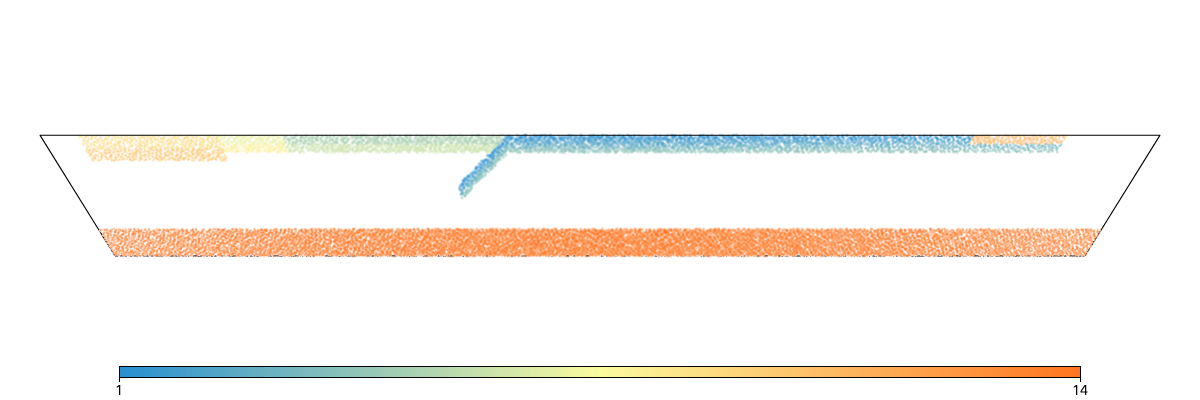

In [17]:
figsize=(1000,300)
camera = ['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > 0


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Save image to disk
# Fig.save("Figure_1.png")

# Rotate camera angle
Fig.script(camera)

# Render in notebook
Fig.show()

In [18]:
def build_tracer_swarm(name, minX, maxX, numX, y, minZ, maxZ, numZ):
    # wrapper for `Model.add_passive_tracers()` which doesn't take dimensional values
    
    minX = GEO.nd(minX) ; maxX = GEO.nd(maxX)
    minZ = GEO.nd(minZ) ; maxZ = GEO.nd(maxZ)
    
    xx = np.linspace(minX, maxX, numX)
    yy = np.array([GEO.nd(y)])
    zz = np.linspace(minZ, maxZ, numZ)

    xx, yy, zz = np.meshgrid(xx,yy,zz)
    
    coords = np.ndarray((xx.size, 3))
    coords[:,0] = xx.ravel()
    coords[:,1] = yy.ravel()
    coords[:,2] = zz.ravel()
       
    tracers = Model.add_passive_tracers(name, vertices = coords)

    return tracers

In [19]:
# # build 2 tracer swarms, one on the surface, and one 25 km down

# DISABLE THE TRACERS! JG23Jun

if dim == 3:
    tracers = build_tracer_swarm("ba_surface",
                                 backarc_xStart, backarc_xStart+backarc_dx, int(np.ceil(backarc_dx/resolution[0])),
                                 0, 
                                 Model.minCoord[2]+resolution[2]/2,Model.maxCoord[2]-resolution[2]/2, Model.elementRes[2]-1)
    tracers.add_tracked_field(Model.strainRate, "sr_tensora", units=u.sec**-1, dataType="double", count=6)

    y = -15*u.km
    t2 = build_tracer_swarm("ba_subsurf",
                                 backarc_xStart, backarc_xStart+backarc_dx+y, int(np.ceil(backarc_dx/resolution[0])),
                                 y, 
                                 Model.minCoord[2]+resolution[2]/2,Model.maxCoord[2]-resolution[2]/2, Model.elementRes[2]-1)
    t2.add_tracked_field(Model.strainRate, "sr_tensorb", units=u.sec**-1, dataType="double", count=6)# # build 2 tracer swarms, one on the surface, and one 25 km down

In [20]:
#FigTracers = vis.Figure(store, figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
# FigTracers.Points(Model.swarm, fn_colour=Model.materialField, 
#            fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# def get_show_tracer(name, colours):
#     t = Model.passive_tracers.get(name)
#     if not t: raise RuntimeError("ERROR: fine tracer called ", name)
    
    # t.variables[0] is the cell index, not of interest, only used to display in 'store'
#    FigTracers.Points(t, t.variables[0],fn_size=2.,
#                      colours=colours,opacity=0.5,colourBar=False)

# if dim == 3:
#
#       get_show_tracer(name="ba_surface", colours="#22BBBB")
#       get_show_tracer(name='ba_subsurf', colours="#335588")
#         get_show_tracer(name='slab', colours="Gray40 Goldenrod")
##         get_show_tracer(name='cont', colours="#335588 #22BBBB")
##         get_show_tracer(name='arc', colours="Goldenrod Grey41")
#         get_show_tracer(name='buoy', colours="#335588 #335588")

# def output_tracers(i):
# 
#     store.step = i
#     # Rotate camera angle
#     #FigTracers.script(camera)
#     
#     #FigTracers.save('foobar.png')

# Render in notebook
# FigTracers.show()

In [21]:
Model.minViscosity = 1e18 * u.Pa * u.sec
Model.maxViscosity = 1e25 * u.Pa * u.sec

In [22]:
if dim == 2:
    Model.set_velocityBCs( left=[0.,None,None], right=[0.,None,None],
                       bottom=[None,0.,None], top=[None,0.,None])
else:
    Model.set_velocityBCs( left=[0.,None,None], right=[0.,None,None],
                       front=[None,0.,None], back=[None,0.,None],
                       bottom=[None,None,0.], top=[None,None,0.])

In [23]:
if rank == 0: print("Calling init_model()...")
Model.init_model()

Calling init_model()...


In [24]:
# force the Eclogite phase transition before the model begins
Model._phaseChangeFn()

In [25]:
figViscosity = vis.Figure(figsize=figsize, axis=True)
figViscosity.append( vis.objects.Points(Model.swarm, Model.viscosityField, colours='dem1', fn_size=2., logScale=True) )
if dim == 3:
    figViscosity.script(camera)
# figViscosity.show()

In [26]:
Fig = vis.Figure(figsize=(1200,400))

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.densityField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Rotate camera angle
#Fig.script(camera)

# Render in notebook
# Fig.show()

In [ ]:
fout = outputPath+'/FrequentOutput.dat'
if rank == 0:
    with open(fout,'a') as f:
         f.write('#step\t time(Myr)\t Vrms(cm/yr)\n')
            
def post_solve_hook():
    vrms = Model.stokes_SLE.velocity_rms()
    step = Model.step
    time = Model.time.m_as(u.megayear)
    
#    if dim==3: output_tracers(step)
    
    if rank == 0:
        with open(fout,'a') as f:
             f.write(f"{step}\t{time:5e}\t{vrms:5e}\n")

        store.step += 1
        figure_one.save("store" + str(shifted))
        figure_one.save("store" + str(shifted) + str(store.step))
    # DEBUG CODE
    #subMesh = Model.mesh.subMesh
    #jeta.data[:] = Model._viscosityFn.evaluate(subMesh)
    #jrho.data[:] = Model._densityFn.evaluate(subMesh)
    #jsig.data[:] = jeta.data[:] * Model.strainRate_2ndInvariant.evaluate(subMesh)
        
Model.post_solve_functions["Measurements"] = post_solve_hook

In [ ]:
## We can test different solvers by uncommentting this section
solver = Model.solver

## OLD SOLVER settings ##
# System level solver options
# solver.options.main.Q22_pc_type = "uwscale"
# solver.options.main.ksp_k2_type = "GMG"
# solver.options.main.ksp_type    = "bsscr"
# solver.options.main.pc_type     = "none"
# solver.options.main.penalty     = 50.
#solver.options.main.list()

# Schur complement solver options
solver.options.scr.ksp_rtol = scr_rtol 
solver.options.scr.ksp_type = "fgmres"
#solver.options.main.list()

# Inner solve (velocity), A11 options
solver.options.A11.ksp_rtol = 1e-1 * scr_rtol
solver.options.A11.ksp_type = "fgmres"
solver.options.A11.list

## OLD SOLVER settings end ##

In [ ]:
if dim == 2: 
    solver.set_inner_method("mumps")
#    solver.options.scr.ksp_rtol = 1e-6 # small tolerance is good in 2D, not sure if too tight for 3D
#else:
#    solver.options.A11.ksp_rtol = 1.0e-5
#    solver.options.scr.ksp_rtol = 1.0e-6 

# solver.print_petsc_options()

In [ ]:
# GEO.rcParams["initial.nonlinear.tolerance"] = 4e-2

In [ ]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, fn_colour=2.*Model.viscosityField*Model.strainRate_2ndInvariant, colours='dem1', logScale=True,fn_size=1.0)
# Fig.show()

In [ ]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, fn_colour=Model._stressField, logScale=True, colours='dem1', fn_size=1.0)
# Fig.show()

In [ ]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, fn_colour=Model._viscosityField, logScale=True, colours='dem1', fn_size=1.0)
# Fig.show()

In [ ]:
## debugging code to generate initial fields for viscosity and density ##
# fields output used to analyse initial setup

#jeta = Model.add_submesh_field(name="cell_vis", nodeDofCount=1)
#jrho = Model.add_submesh_field(name="cell_rho", nodeDofCount=1)
#jsig = Model.add_submesh_field(name="cell_sig", nodeDofCount=1)
#
#GEO.rcParams["default.outputs"].append("cell_vis")
#GEO.rcParams["default.outputs"].append("cell_rho")
#GEO.rcParams["default.outputs"].append("cell_sig")
#
#subMesh = Model.mesh.subMesh
#jeta.data[:] = Model._viscosityFn.evaluate(subMesh)
#jrho.data[:] = Model._densityFn.evaluate(subMesh)
#jsig.data[:] = 2. * jeta.data[:] * Model.strainRate_2ndInvariant.evaluate(subMesh)

In [ ]:
# To restart the model
# Model.run_for(nstep=200, checkpoint_interval=5, restartStep=-1)

In [ ]:
Model.run_for(nstep=200, checkpoint_interval=1)

In [ ]:
#RESTART

In [ ]:
Model.run_for(nstep=200, restartStep=78, restartDir="output-1e-06-20-620-50x50_np1")
#Model.run_for(nstep=200, checkpoint_interval=5, restartStep=52, restartDir="output-1e-06-20-700-20x20_np1")

In [ ]:
figsize=(1000,300)
camera = ['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > 0


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Save image to disk
# Fig.save("Figure_1.png")

# Rotate camera angle
#Fig.script(camera)

# Render in notebook
Fig.show()

In [ ]:
ribbon_dx =  500. * u.kilometer
ribbon_dy =   50. * u.kilometer
ribbon_dz = 1500. * u.kilometer 
ribbon_xStart = slab_xStart + shifted * u.kilometer
rib.shape = GEO.shapes.Box(top=0*u.km, bottom=-50*u.km,
                           minX=ribbon_xStart, maxX=ribbon_xStart+ribbon_dx)

matField = Model.swarm_variables['materialField']
rib.index
matField.data
Model.swarm.data
isInsideShape = rib.shape.evaluate(Model.swarm.data)# where particle is inside the ribbon update it's materialField index
Model.swarm_variables['materialField'].data[:] = np.where(isInsideShape == True, rib.index, matField.data )

In [ ]:
figsize=(1000,300)
camera = ['rotate x 30']
boundingBox=( minCoord, maxCoord )

materialFilter = Model.materialField > 0


# ERROR with boundaringBox, maybe BUG for Okaluza
# figSwarm = vis.Figure(figsize=figsize, boundingBox=boundingBox )

# swarmPlot = vis.objects.Points(swarm, materialIndex, materialFilter, colours='gray', opacity=0.5, fn_size=2., 
#                                     discrete=True, colourBar=False, )

Fig = vis.Figure(figsize=(1200,400))

# Show single colour
# Fig.Points(Model.swarm, colour='gray', opacity=0.5, discrete=True, 
#            fn_mask=materialFilter, fn_size=2.0, colourBar=False)

# Show all glory
Fig.Points(Model.swarm, fn_colour=Model.materialField, 
           fn_mask=materialFilter, opacity=0.5, fn_size=2.0)

# Save image to disk
# Fig.save("Figure_1.png")

# Rotate camera angle
#Fig.script(camera)

# Render in notebook
Fig.show()

In [ ]:
Model.run_for(nstep=200, checkpoint_interval=1)

In [ ]:
from UWGeodynamics import visualisation as vis
view = vis.Viewer(store)
steps = view.steps
view.step = steps[20]
for i in view.figures:
    view.figure(i)
    view["title"] = "Timestep ##"
    view.window()

In [ ]:
figs = view.figures
steps = view.steps
view.step = steps[20]
for i in view.figures:
    view.figure(i)
    view["title"] = "Timestep ##"
    view.show()

In [ ]:
figs = view.figures
steps = view.steps
view.step = steps[90]
for i in view.figures:
    view.figure(i)
    view["title"] = "Timestep ##"
    view.show()